In [1]:
from pickle import EMPTY_DICT

from hamcrest import empty
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph langchain_community langchain_anthropic langchain_experimental

In [356]:
from typing import TypedDict, Literal
from langgraph.graph import MessagesState, END, START, StateGraph
from langgraph.types import Command
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI
from dotenv import find_dotenv, load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from IPython.display import Image, display
from typing import TypedDict, Optional, Dict, List
from pydantic import BaseModel
from typing import Literal
from typing import Annotated
from operator import add

In [357]:
# Cargar variables de entorno
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)

True

In [358]:
# Primero defino un estado para el input del usuario

# Estado de Entrada: Contiene la consulta que hará el usuario
class InputState(TypedDict):
    user_input: str
    context: Optional[Dict]

# Estado de Salida
class OutputState(TypedDict):
    graph_output: str

# ¿Luego defino un estado para el supervisor?
class SupervisorState(TypedDict):
    user_input: str
    graph_output: str
    agent_responses: Annotated[list[str], add]  # ✅ Asegurarse de que el nombre sea consistente con el uso
    conversation_history: Annotated[list[str], add]  # ✅ Agregar historial de conversación
    task_status: Dict[str, str]

# Definir un estado para el agente Buker
class BukerState(TypedDict):
    buker_response: Annotated[List[str], add]

# Definir un estado para el agente Planner
class PlannerState(TypedDict):
    planner_response: Annotated[List[str], add]

# Difinir un estado para el agente Reglamento
class ReglamentoState(TypedDict):
    reglamento_response: Annotated[List[str], add]

# Definir un estado para el agente de Search_web
class SearchState(TypedDict):
    search_results: Optional[List[str]]

In [359]:
# Definir quienes serán los miembros de la arquitectuta
miembros = ["buker", "planner", "reglamento", "search_web"]
options = ["buker", "planner", "reglamento", "search_web","FINISH"]

In [360]:
system_prompt = (
    "Eres un supervisor encargado de gestionar una conversación entre los"
    f" siguientes trabajadores: {miembros}. Dada la siguiente solicitud del usuario,"
    " responde con el trabajador que debe actuar a continuación. Cada trabajador"
    " realizará una tarea y responderá con sus resultados y estado. Cuando termine,"
    " responde con FINISH."
)


In [361]:
# Configurar modelo de lenguaje
llm = ChatOpenAI(model="gpt-4o")

In [362]:
class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""
    next: Literal["buker", "planner", "reglamento", "search_web", "FINISH"]
print(Router())

{}


In [363]:
def amparo_node(state: SupervisorState) -> Command[Literal["buker", "planner", "reglamento", "search_web", "__end__"]]:
    messages = [{"role": "system", "content": system_prompt}] + [
        {"role": "user", "content": msg} for msg in state.get("conversation_history", [])
    ]

    # print("📌 Mensajes enviados al modelo:", messages)

    response = llm.with_structured_output(Router).invoke(messages)
    # print("📌 Respuesta del modelo:", response)

    goto = response["next"]
    # print("📌 Próximo nodo:", goto)

    # 🔹 Obtener o inicializar task_status
    task_status = state.get("task_status", {})

    # 🔹 Inicializar todas las tareas como "pendiente" si task_status está vacío
    if not task_status:
        task_status = {tarea: "pendiente" for tarea in ["buker", "planner", "reglamento", "search_web"]}
        # print(f"🔄 Inicializando task_status: {task_status}")

    # 🔹 Verificar si todas las tareas han sido completadas
    if all(status == "completado" for status in task_status.values()):
        # print("✅ Todas las tareas fueron completadas. Finalizando el flujo.")
        return Command(goto=END)  # 🚀 Finaliza la ejecución

    # 🔹 Si el supervisor sigue asignando la misma tarea completada, evitar el bucle
    if task_status.get(goto) == "completado":
        # print(f"⚠️ La tarea {goto} ya está completada. Buscando otro nodo...")
        tareas_pendientes = [tarea for tarea, estado in task_status.items() if estado == "pendiente"]
        if tareas_pendientes:
            goto = tareas_pendientes[0]  # Selecciona la primera tarea pendiente
        else:
            # print("✅ Todas las tareas se completaron, finalizando flujo.")
            return Command(goto=END)

    # 🔹 Marcar la tarea seleccionada como "pendiente"
    task_status[goto] = "pendiente"

    updated_state = {
        "conversation_history": state.get("conversation_history", []) + [f"Supervisor asignó tarea a {goto}"],
        "task_status": task_status  # ✅ Se actualiza correctamente
    }

    return Command(goto=goto, update=updated_state)


In [364]:
# Nodo de Buker
def buker_node(state: SupervisorState) -> Command:
    user_input = state["user_input"]

    # 🔹 Simulación de respuesta desde Buker
    buker_response = f"Consulta en BUK realizada para: {user_input}"

    # 🔹 Actualizar el estado con la respuesta de Buker
    updated_state = {
        "agent_responses": state.get("agent_responses", []) + [buker_response],
        "task_status": {**state.get("task_status", {}), "buker": "completado"},
    }

    print(f"✅ Buker completó la tarea. Estado actualizado: {updated_state}")

    return Command(update=updated_state, goto="amparo")


In [365]:
# Nodo de Planner
def planner_node(state: SupervisorState) -> Command:
    user_input = state["user_input"]

    # 🔹 Simulación de planificación de tareas
    planner_response = f"Tareas planificadas para: {user_input}"

    # 🔹 Actualizar el estado con la respuesta del Planner
    updated_state = {
        "agent_responses": state.get("agent_responses", []) + [planner_response],
        "task_status": {**state.get("task_status", {}), "planner": "completado"},
    }

    print(f"✅ Planner completó la tarea. Estado actualizado: {updated_state}")

    return Command(update=updated_state, goto="amparo")


In [366]:
# Nodo de Reglamento
def reglamento_node(state: SupervisorState) -> Command:
    user_input = state["user_input"]

    # 🔹 Simulación de respuesta del reglamento interno
    reglamento_response = f"Consulta de reglamento respondida para: {user_input}"

    # 🔹 Actualizar el estado con la respuesta del reglamento
    updated_state = {
        "agent_responses": state.get("agent_responses", []) + [reglamento_response],
        "task_status": {**state.get("task_status", {}), "reglamento": "completado"},
    }

    print(f"✅ Reglamento completó la tarea. Estado actualizado: {updated_state}")

    return Command(update=updated_state, goto="amparo")


In [367]:
# Herramientas de Search Web
# Configurar herramientas de búsqueda
tavily_tool = TavilySearchResults(max_results=1)
"""
# Crear agente de investigación
research_agent = create_react_agent(
    llm, tools=[tavily_tool], prompt="Eres un agente especializado en busqueda web"
)"""

'\n# Crear agente de investigación\nresearch_agent = create_react_agent(\n    llm, tools=[tavily_tool], prompt="Eres un agente especializado en busqueda web"\n)'

In [368]:
# Nodo de Search Web
def search_web(state: SupervisorState) -> Command:
    user_query = state["user_input"]  # Obtener la consulta del usuario
    
    # 🔹 Realizar la búsqueda en la web
    search_results = tavily_tool.invoke(user_query)

    # 🔹 Actualizar el estado con los resultados obtenidos
    updated_state = {
        "agent_responses": state.get("agent_responses", []) + [f"Resultados de búsqueda: {search_results}"],
        "task_status": {**state.get("task_status", {}), "search_web": "completado"},
    }

    print(f"✅ Búsqueda web completada para: {user_query}")
    print(updated_state)
    
    return Command(update=updated_state, goto="amparo")  # Regresa al supervisor

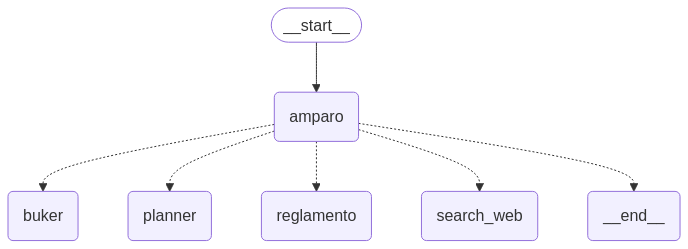

In [369]:
builder = StateGraph(SupervisorState, input=InputState, output=OutputState)
builder.add_node("amparo", amparo_node)
builder.add_node("buker", buker_node)
builder.add_node("planner", planner_node)
builder.add_node("reglamento", reglamento_node)
builder.add_node("search_web", search_web)

# Definir conexiones entre nodos
builder.add_edge(START, "amparo")
# builder.add_edge("amparo", "buker")
# builder.add_edge("buker", "amparo")
# builder.add_edge("amparo", "planner")
# builder.add_edge("planner", "amparo")
# builder.add_edge("amparo", "reglamento")
# builder.add_edge("reglamento", "amparo")
# builder.add_edge("amparo", "search_web")
#builder.add_edge("search_web", "amparo")
# builder.add_edge("amparo", END)  # ✅ Asegurar que END es un valor válido

# Compilar y mostrar el gráfico de estados
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [354]:
response = graph.invoke({"user_input": "Busca en internet quien es el presidente de los Estados Unidos de América"})
print(response)

✅ Planner completó la tarea. Estado actualizado: {'agent_responses': ['Tareas planificadas para: Busca en internet quien es el presidente de los Estados Unidos de América'], 'task_status': {'buker': 'pendiente', 'planner': 'completado', 'reglamento': 'pendiente', 'search_web': 'pendiente'}}
✅ Buker completó la tarea. Estado actualizado: {'agent_responses': ['Tareas planificadas para: Busca en internet quien es el presidente de los Estados Unidos de América', 'Consulta en BUK realizada para: Busca en internet quien es el presidente de los Estados Unidos de América'], 'task_status': {'buker': 'completado', 'planner': 'completado', 'reglamento': 'pendiente', 'search_web': 'pendiente'}}
✅ Reglamento completó la tarea. Estado actualizado: {'agent_responses': ['Tareas planificadas para: Busca en internet quien es el presidente de los Estados Unidos de América', 'Tareas planificadas para: Busca en internet quien es el presidente de los Estados Unidos de América', 'Consulta en BUK realizada pa